# Directed Acyclic Graphs

> **Reference:** *Causal Inference: The Mixtape*, Chapter 3: Directed Acyclic Graphs (pp. 67-117)

This lecture introduces directed acyclic graphs (DAGs) as a tool for reasoning about causal relationships. We apply these concepts using the Online Retail Simulator to answer: **Why does our naive analysis suggest content optimization hurts sales?**

---

## Part I: Theory

This section covers the theoretical foundations of directed acyclic graphs as presented in Cunningham's *Causal Inference: The Mixtape*, Chapter 3.

In [1]:
# Standard library
import inspect

# Third-party packages
from IPython.display import Code

# Local imports
from support import draw_police_force_example, simulate_police_force_data

## 1. Introduction to DAG Notation

A **directed acyclic graph (DAG)** is a visual representation of causal relationships between variables.

### Core Components

| Element | Representation | Meaning |
|---------|----------------|----------|
| **Node** | Circle | A random variable |
| **Arrow** | Directed edge (→) | Direct causal effect |
| **Path** | Sequence of edges | Connection between variables |

### Key Properties

1. **Directed**: Arrows point in one direction (cause → effect)
2. **Acyclic**: No variable can cause itself (no loops)
3. **Causality flows forward**: Time moves in the direction of arrows

### What DAGs Encode

DAGs encode **qualitative causal knowledge**:
- What IS happening: drawn arrows
- What is NOT happening: missing arrows (equally important!)

A missing arrow from A to B claims that A does not directly cause B.

### Simple DAG: Treatment → Outcome

![Simple Causal Relationship](dag_simple.svg)

## 2. Paths: Direct and Backdoor

A **path** is any sequence of edges connecting two nodes, regardless of arrow direction.

### Types of Paths

| Path Type | Direction | Interpretation |
|-----------|-----------|----------------|
| **Direct/Causal** | D → ... → Y | The causal effect we want |
| **Backdoor** | D ← ... → Y | Spurious correlation (bias!) |

### The Backdoor Problem

Backdoor paths create **spurious correlations** between D and Y:
- They make D and Y appear related even without a causal effect
- This is the graphical representation of **selection bias**

![Confounded Relationship](dag_confounder.svg)

### Path Analysis

| Path | Type |
|------|------|
| D → Y | Direct causal path (what we want to estimate) |
| D ← X → Y | Backdoor path (creates bias) |

## 3. Confounders

A **confounder** is a variable that:
1. Causes the treatment (D)
2. Causes the outcome (Y)
3. Is NOT on the causal path from D to Y

### Observed vs. Unobserved

| Type | In DAG | Implication |
|------|--------|-------------|
| **Observed** | Solid circle | Can condition on it |
| **Unobserved** | Dashed circle | Cannot directly control |

### Classic Example: Education and Earnings

Consider estimating the return to education:
- **Treatment**: Years of education
- **Outcome**: Earnings
- **Confounders**: Ability, family background, motivation

People with higher ability tend to:
- Get more education (ability → education)
- Earn more regardless of education (ability → earnings)

This creates a backdoor path that inflates naive estimates of education's effect.

![Education and Earnings DAG](dag_education.svg)

## 4. Colliders and Collider Bias

A **collider** is a variable where two arrows point INTO it:

![Collider Structure](dag_collider.svg)

### Key Insight About Colliders

Colliders have a **special property**: they naturally BLOCK paths!

| Situation | Path Status |
|-----------|-------------|
| Leave collider alone | Path is CLOSED (blocked) |
| Condition on collider | Path is OPENED (creates bias!) |

### Why Conditioning Opens Colliders

Conditioning on a collider makes its causes appear correlated, even if they're independent in the population.

### Police Use of Force: Sample Selection as a Collider

Consider studying whether police use more force against minorities:

- **D (Treatment)**: Minority status
- **Y (Outcome)**: Use of force
- **M (Collider)**: Police stop (sample selection)
- **U (Unobserved)**: Suspicion/perceived threat

![Police Use of Force DAG](police_force_dag.svg)

**The selection problem:**
- Minorities are more likely to be stopped (D → M)
- Suspicion affects both stops and force (U → M, U → Y)
- Administrative data only includes stopped individuals

**Why this attenuates discrimination estimates:**

Among stopped individuals (M = 1), non-minorities (D = 0) who got stopped probably had high suspicion (U)—that's why they were stopped. Minorities (D = 1) who got stopped could have low or high suspicion, since they face higher stop rates regardless. So within the stopped sample, non-minorities are disproportionately high-suspicion, which correlates with more force (Y). This narrows the apparent gap between groups, masking the true discrimination effect (D → Y).

### Simulation Setup

<div class="alert alert-block alert-info">
<b>Why Show the Simulation Code?</b>

In causal inference, we face a fundamental challenge: we can never directly observe causal effects in real data. When we analyze observational data, we don't know the true causal structure—we can only make assumptions and hope our methods recover something meaningful. Simulation flips this around. By <i>constructing</i> data with a known causal structure, we create a laboratory where we can verify whether our intuitions and methods actually work. In the code below, we explicitly encoded that minorities face discrimination and that suspicion affects both stops and force. Because we built these relationships ourselves, we know the ground truth. This lets us <i>see</i>—not just theorize—how conditioning on a collider distorts our estimates. Throughout this course, simulation serves as our proving ground: if a method can't recover known effects in simulated data, we shouldn't trust it with real data where the stakes are higher and the truth is hidden.
</div>

The following function generates synthetic data with the collider structure described above:

In [2]:
Code(inspect.getsource(simulate_police_force_data), language="python")

def simulate_police_force_data(n_population=5000, discrimination_effect=0.3, seed=42):
    """
    Simulate police stop data with collider bias structure.

    The DAG structure:
        Minority (D) → Stop (M) ← Suspicion (U)
        Minority (D) → Force (Y)
        Suspicion (U) → Force (Y)

    Where Stop (M) is the collider that creates sample selection bias.

    Parameters
    ----------
    n_population : int
        Size of the simulated population.
    discrimination_effect : float
        True causal effect of minority status on force (0 = no discrimination).
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    pandas.DataFrame
        DataFrame with columns:
        - minority: minority status (0 or 1)
        - suspicion: suspicion scores
        - is_stopped: boolean stop status
        - force_score: force scores
    """
    rng = np.random.default_rng(seed)

    # Minority status (binary treatment)
    minority = rng.choice([0, 1], size=n_population, p=[0.7, 0.3])

    # Suspicion/perceived threat (unobserved confounder)
    suspicion = rng.normal(50, 15, n_population)

    # Stop probability depends on minority status AND suspicion
    # Minorities are more likely to be stopped (D → M)
    # Higher suspicion leads to more stops (U → M)
    stop_score = (
        0.3 * suspicion  # Suspicion affects stops
        + 15 * minority  # Minorities more likely stopped
        + rng.normal(0, 10, n_population)
    )
    is_stopped = stop_score > np.percentile(stop_score, 70)

    # Force depends on suspicion and minority status
    # True discrimination effect is the parameter
    force_score = (
        0.5 * suspicion  # Higher suspicion → more force (U → Y)
        + discrimination_effect * 20 * minority  # True discrimination (D → Y)
        + rng.normal(0, 10, n_population)
    )

    return pd.DataFrame({
        "minority": minority,
        "suspicion": suspicion,
        "is_stopped": is_stopped,
        "force_score": force_score,
    })

In [3]:
# Simulate population data
police_data = simulate_police_force_data(n_population=5000, discrimination_effect=0.3, seed=42)
police_data

,minority,suspicion,is_stopped,force_score
0,1,33.516132,True,13.429162
1,0,41.880285,True,20.398594
2,1,54.080017,True,29.253445
3,0,40.575200,False,28.486508
4,0,45.824503,False,31.391469
...,...,...,...,...
4995,0,62.382881,False,21.783496
4996,0,23.108498,False,13.325042
4997,0,34.363115,False,30.535183
4998,0,19.034540,False,13.382449


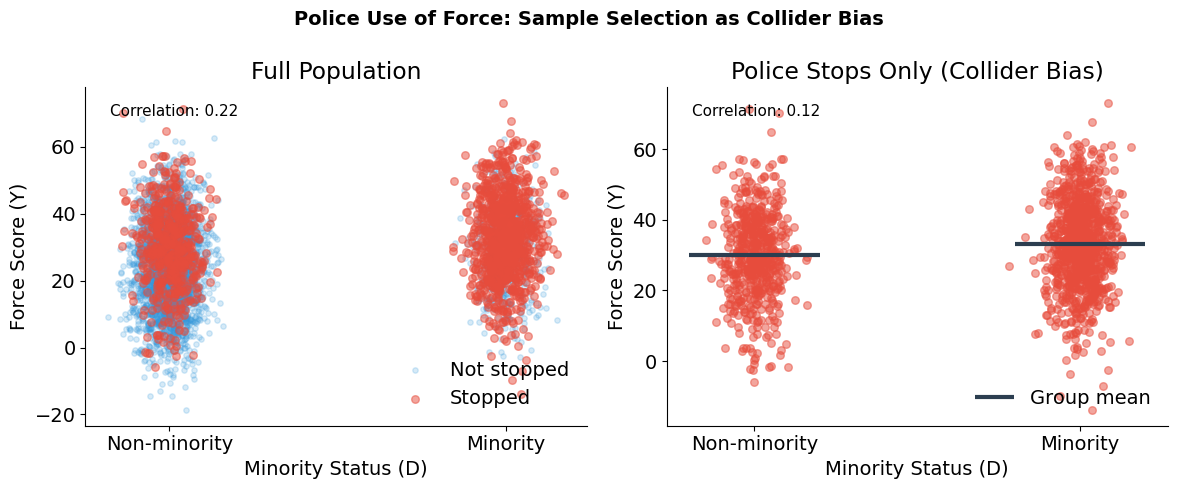

In [4]:
# Visualize collider bias
draw_police_force_example(police_data)

### Collider Bias in Action

**True discrimination effect:** 30% increase in force for minorities

| Sample | Correlation (Minority ↔ Force) |
|--------|-------------------------------|
| Full population | r = 0.22 |
| Stopped individuals only | r = 0.12 |

This is **collider bias**: conditioning on Stop (which depends on both Minority and Suspicion) creates a spurious association. The administrative data only includes stopped individuals, so naive analysis of police records may produce misleading estimates of discrimination.

## 5. The Backdoor Criterion

The **backdoor criterion** provides a systematic way to identify what variables to condition on.

### Definition

A set of variables $Z$ satisfies the backdoor criterion relative to $(D, Y)$ if:

1. No variable in $Z$ is a descendant of $D$
2. $Z$ blocks every backdoor path from $D$ to $Y$

### How to Block Paths

| Node Type | To Block | To Open |
|-----------|----------|----------|
| **Non-collider** | Condition on it | Leave alone |
| **Collider** | Leave alone | Condition on it |

### Important Implications

1. **Not all controls are good controls**: Conditioning on a collider creates bias
2. **Minimal sufficiency**: You don't need to condition on everything—just enough to block backdoors
3. **Multiple solutions**: Often several valid conditioning sets exist

## 6. Choosing the Right Estimand

The backdoor criterion tells us how to block spurious paths. But DAGs also help us reason about a subtler question: **which causal effect do we actually want to estimate?**

Sometimes a variable is neither a confounder nor a collider—it's a **mediator** on the causal path. Whether to condition on it depends on the research question, not on removing bias.

### Example: Discrimination in Hiring

Consider studying gender discrimination in wages:
- Gender → Occupation (women steered to lower-paying jobs)
- Gender → Wages (direct discrimination)
- Occupation → Wages

**Question**: Should we control for occupation?

**Answer**: It depends on what effect we want to measure!
- **Total effect**: Don't control (captures both direct and indirect discrimination)
- **Direct effect**: Control for occupation (discrimination within same job)

![Gender Discrimination DAG](dag_discrimination.svg)

---

## Part II: Application

We now apply DAG concepts to diagnose and solve a confounding problem using simulated data.

In [5]:
# Third-party packages
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

# Local imports
from online_retail_simulator import simulate, load_job_results
from support import (
    apply_confounded_treatment,
    create_quality_score,
    plot_confounding_scatter,
    plot_dag_application,
)

# Fix seed for reproducibility so that all results in this notebook are deterministic
np.random.seed(42)

## 1. Business Context: The Content Optimization Paradox

An e-commerce company ran a content optimization program for some of its products. When they analyze the results, they find something puzzling:

> **Products that received content optimization tend to have LOWER sales than those that didn't.**

The content team is confused. Did their optimization work actually hurt sales?

### The Underlying Reality

What's actually happening:
- **Struggling products** (low quality) were selected for content optimization
- **Strong products** (high quality) sell well without optimization
- Content optimization **does** increase sales (true causal effect is positive)

But the **confounding** from product quality creates a **negative spurious correlation** that overwhelms the positive causal effect. This is exactly the scenario we explored in Lecture 01—but now we'll use DAGs to understand and solve it.

## 2. Drawing the DAG

Let's represent this situation graphically:

- **Quality** (`Q`): Product quality/strength (unobserved)
- **Optimization** (`D`): Content optimization treatment
- **Sales** (`Y`): Revenue

Relationships:
1. Quality → Sales (+): Better products sell more
2. Quality → Optimization (−): Struggling products get optimized first
3. Optimization → Sales (+): Optimization increases sales (TRUE causal effect)

![Content Optimization Paradox DAG](dag_optimization.svg)

### Path Analysis

| Path | Type | Effect |
|------|------|--------|
| Optimization → Sales | Direct (causal) | True causal effect (+50% revenue boost) |
| Optimization ← Quality → Sales | Backdoor | Creates negative bias (quality confounding) |

## 3. Generating Data with the Online Retail Simulator

We use the **Online Retail Simulator** to generate realistic e-commerce data. The simulation configuration is defined in `"config_simulation.yaml"`. This gives us products with baseline sales metrics that we can then use to demonstrate confounding.

### Data Generation Process

1. **Simulate baseline data**: Generate products and their sales metrics
2. **Create quality score**: Derive a quality measure from baseline revenue (the confounder)
3. **Apply confounded treatment**: Assign content optimization based on quality (not randomly!)
4. **Calculate outcomes**: Apply the true treatment effect to get observed sales

In [6]:
# Step 1: Generate baseline data using the simulator
! cat "config_simulation.yaml"

STORAGE:
  PATH: output

RULE:
  CHARACTERISTICS:
    FUNCTION: simulate_characteristics_rule_based
    PARAMS:
      num_products: 500
      seed: 42

  METRICS:
    FUNCTION: simulate_metrics_rule_based
    PARAMS:
      date_start: "2024-11-15"
      date_end: "2024-11-15"
      sale_prob: 0.7
      seed: 42

PRODUCT_DETAILS:
  FUNCTION: simulate_product_details_mock


In [7]:
# Run simulation
job_info = simulate("config_simulation.yaml")

In [8]:
# Load simulation results
metrics = load_job_results(job_info)["metrics"]

print(f"Metrics records: {len(metrics)}")

Metrics records: 500


### Creating the Confounded Treatment Assignment

Now we create the confounding structure:
1. **Quality score**: Derived from baseline revenue (high revenue → high quality)
2. **Treatment assignment**: Low quality products are more likely to be selected for optimization

This mimics a realistic business scenario where struggling products get prioritized for improvement.

In [9]:
# Step 2: Create quality score from baseline revenue
quality_df = create_quality_score(metrics, seed=42)

# Step 3: Apply confounded treatment assignment
# Low quality products more likely to be optimized (negative quality_effect)
TRUE_EFFECT = 0.5  # 50% revenue boost from optimization
QUALITY_EFFECT = -0.05  # Negative: low quality products are more likely to be treated

confounded_products = apply_confounded_treatment(
    quality_df,
    treatment_fraction=0.3,
    quality_effect=QUALITY_EFFECT,
    true_effect=TRUE_EFFECT,
    seed=42,
)

print(f"Total products:     {len(confounded_products)}")
print(f"Optimized products: {confounded_products['D'].sum()} ({confounded_products['D'].mean():.1%})")
print(f"\nQuality score by treatment status:")
print(f"  Control (not optimized): {confounded_products[confounded_products['D'] == 0]['quality_score'].mean():.1f}")
print(f"  Treated (optimized):     {confounded_products[confounded_products['D'] == 1]['quality_score'].mean():.1f}")
print(f"\n-> Treated products have LOWER quality on average (confounding!)")

Total products:     500
Optimized products: 157 (31.4%)

Quality score by treatment status:
  Control (not optimized): 13.0
  Treated (optimized):     9.5

-> Treated products have LOWER quality on average (confounding!)


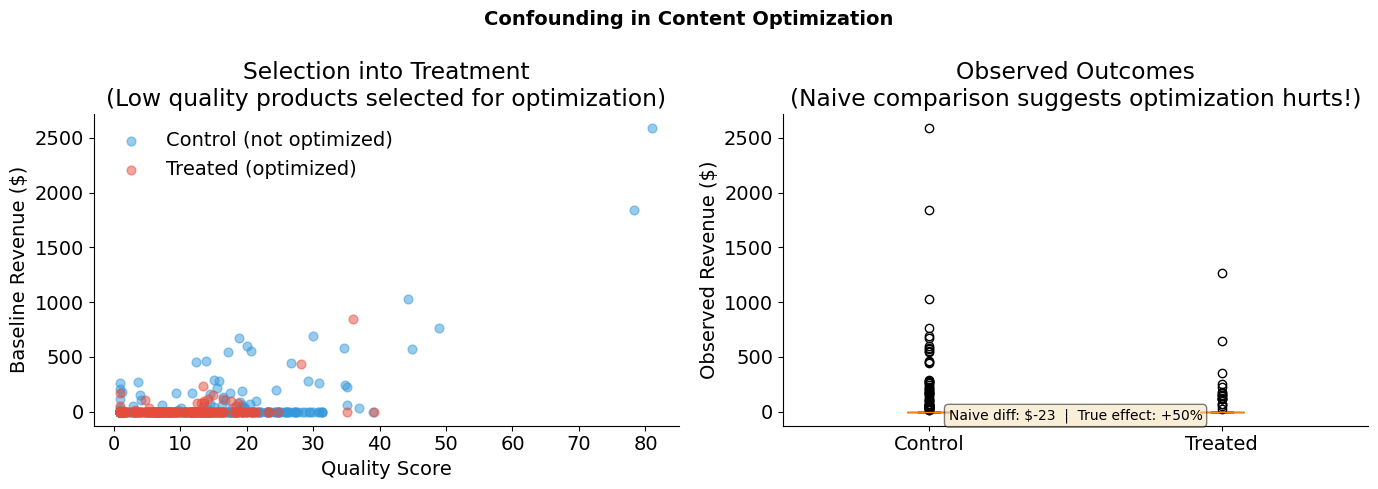

In [10]:
# Visualize the confounding structure
plot_confounding_scatter(confounded_products, title="Confounding in Content Optimization")

## 4. What Does Naive Analysis Tell Us?

Let's start with what a naive analyst might do: compare average sales between optimized and non-optimized products.

In [11]:
# Naive comparison: difference in means
treated = confounded_products[confounded_products["D"] == 1]
control = confounded_products[confounded_products["D"] == 0]

naive_estimate = treated["Y_observed"].mean() - control["Y_observed"].mean()

print("Naive Comparison: Optimized vs. Non-Optimized Products")
print("=" * 55)
print(f"Mean revenue (optimized):     ${treated['Y_observed'].mean():,.2f}")
print(f"Mean revenue (not optimized): ${control['Y_observed'].mean():,.2f}")
print(f"Naive estimate:               ${naive_estimate:,.2f}")
print(f"\nTrue effect: +{TRUE_EFFECT:.0%} revenue boost")
print(f"\n-> The naive estimate suggests optimization HURTS sales!")

Naive Comparison: Optimized vs. Non-Optimized Products
Mean revenue (optimized):     $26.90
Mean revenue (not optimized): $49.98
Naive estimate:               $-23.08

True effect: +50% revenue boost

-> The naive estimate suggests optimization HURTS sales!


## 5. How Do We Apply the Backdoor Criterion?

### Step 1: List all paths from Optimization to Sales

1. **Optimization → Sales** (direct, causal)
2. **Optimization ← Quality → Sales** (backdoor, non-causal)

### Step 2: Identify which paths are open/closed

- Path 1: Always open (it's causal)
- Path 2: Open because Quality is a non-collider on this path

### Step 3: Find conditioning set to block backdoors

To block the backdoor path **Optimization ← Quality → Sales**:
- Condition on **Quality**

This satisfies the backdoor criterion:
- Quality is not a descendant of Optimization
- Conditioning on Quality blocks the backdoor path

## 6. How Do We Recover the Causal Effect?

Now we condition on quality to close the backdoor path. We use regression to estimate the effect while controlling for the confounder.

In [12]:
# Naive regression: Sales ~ Optimization (ignoring quality)
naive_results = smf.ols("Y_observed ~ D", data=confounded_products).fit()

# Conditioned regression: Sales ~ Optimization + Quality
conditioned_results = smf.ols("Y_observed ~ D + quality_score", data=confounded_products).fit()

print("Naive Regression: Y ~ D")
print("=" * 50)
print(naive_results.summary().tables[1])

print("\n\nConditioned Regression: Y ~ D + Quality")
print("=" * 50)
print(conditioned_results.summary().tables[1])

print(f"\nNaive estimate:       ${naive_results.params['D']:,.2f}")
print(f"Conditioned estimate: ${conditioned_results.params['D']:,.2f}")
print(f"True effect:          +{TRUE_EFFECT:.0%} boost")
print(f"\n-> Conditioning on quality recovers the POSITIVE effect!")

Naive Regression: Y ~ D
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     49.9837     10.094      4.952      0.000      30.151      69.817
D            -23.0827     18.014     -1.281      0.201     -58.476      12.311


Conditioned Regression: Y ~ D + Quality
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -82.7060     12.742     -6.491      0.000    -107.740     -57.672
D                13.1344     15.473      0.849      0.396     -17.267      43.536
quality_score    10.1740      0.724     14.045      0.000       8.751      11.597

Naive estimate:       $-23.08
Conditioned estimate: $13.13
True effect:          +50% boost

-> Conditioning on quality recovers the POSITIVE effect!


/home/peisenha/office/business/eisenhauer-io/courses/business-decisions/docs/source/measure-impact/02-directed-acyclic-graphs/support.py:404: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


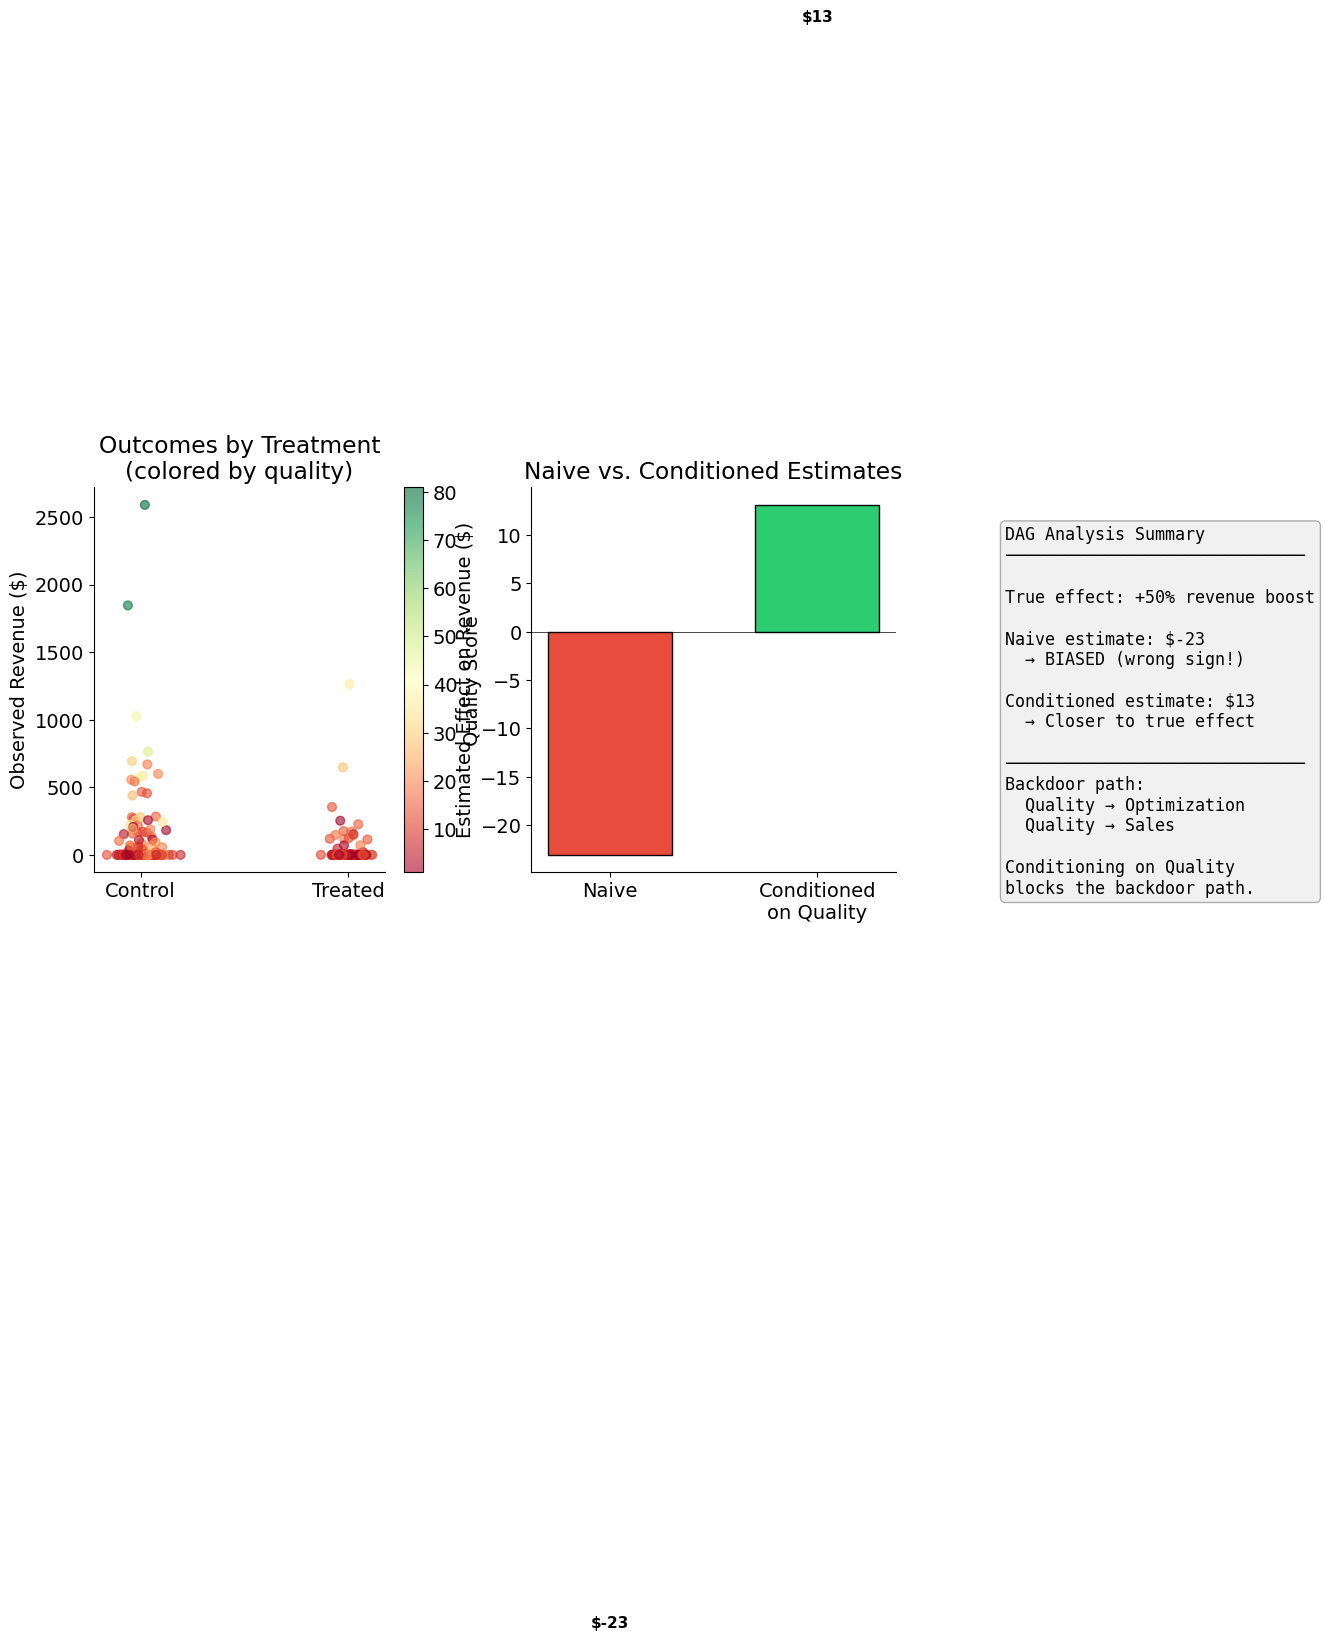

In [13]:
# Visual summary
plot_dag_application(
    confounded_products,
    naive_effect=naive_results.params["D"],
    conditioned_effect=conditioned_results.params["D"],
    true_effect=TRUE_EFFECT,
)

In [14]:
# Final summary
print("\n" + "=" * 60)
print("SUMMARY: Content Optimization Effect Estimates")
print("=" * 60)
print(f"True causal effect:                  +{TRUE_EFFECT:.0%} revenue boost")
print(f"\nNaive (ignoring quality):            ${naive_results.params['D']:,.2f}  ← WRONG SIGN!")
print(f"Conditioned on quality (correct):    ${conditioned_results.params['D']:,.2f}  ← POSITIVE!")
print("=" * 60)


SUMMARY: Content Optimization Effect Estimates
True causal effect:                  +50% revenue boost

Naive (ignoring quality):            $-23.08  ← WRONG SIGN!
Conditioned on quality (correct):    $13.13  ← POSITIVE!


## Additional resources

- **Bellemare, M. & Bloem, J. (2020)**. The paper of how: Estimating treatment effects using the front-door criterion. *Working Paper*.

- **Hünermund, P. & Bareinboim, E. (2019)**. Causal inference and data-fusion in econometrics. *arXiv preprint arXiv:1912.09104*.

- **Imbens, G. W. (2020)**. Potential outcome and directed acyclic graph approaches to causality: Relevance for empirical practice in economics. *Journal of Economic Literature*, 58(4), 1129-1179.

- **Manski, C. F. (1995)**. *Identification Problems in the Social Sciences*. Harvard University Press.

- **Morgan, S. L. & Winship, C. (2014)**. *Counterfactuals and Causal Inference*. Cambridge University Press.

- **Pearl, J. (2009a)**. *Causality: Models, Reasoning, and Inference* (2nd ed.). Cambridge University Press.

- **Pearl, J. (2009b)**. Causal inference in statistics: An overview. *Statistics Surveys*, 3, 96-146.

- **Pearl, J. (2012)**. The do-calculus revisited. *Proceedings of the 28th Conference on Uncertainty in Artificial Intelligence*.

- **Peters, J., Janzing, D. & Schölkopf, B. (2017)**. *Elements of Causal Inference: Foundations and Learning Algorithms*. MIT Press.